# Exploratory Data Analysis of Speech Datasets
Including the VariaNTS, IFA Dialog, IFA, and VoxForge speech audio datasets

In [1]:
from importlib import reload
from multiprocessing import Pool
import os
from pathlib import Path
from sys import getsizeof
from typing import Tuple

import aifc
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from pydub import AudioSegment
from pydub.silence import detect_silence
from scipy.fft import rfft, rfftfreq
from scipy.io import wavfile
import scipy.signal as signal
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tqdm import tqdm
from umap import UMAP

import data_processing as dp
import utils
from utils import *
reload(utils)


import IPython.display as ipd

/home/passch/.conda/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%matplotlib inline

In [3]:
# Set the number of processes to spawn for multiprocessing
NUM_PROCESSES = 16

## VariaNTS


In the following, we process information about the VariaNTS corpus as pandas dataframe.

In [4]:
path = DataPaths.VariaNTS

audio_files = []

# wordtypes_to_use = ['words', 'nonwords', 'predsent', 'anomsent']
wordtypes_to_use = ['words']

for person in os.listdir(path):
    if os.path.isdir(path/person):
        for wordtype in os.listdir(path/person):
            # Only use the word types which we designate to be used
            use_wordtype = wordtype.split('_')[-1] in wordtypes_to_use
            if use_wordtype and os.path.isdir(path/person/wordtype):
                for fn in os.listdir(path/person/wordtype):
                    if fn.split('.')[-1] == 'wav':
                        audio_files.append(str(path/person/wordtype/fn))

In [5]:
dataproc = dp.DataProcessor()

In [6]:
def extract_VariaNTS(file_path: str):
    """
    file_path : absolute path to the file on disk
    """

    sound = AudioSegment.from_file(file_path)

    split_path = file_path.split('/')
    # Person is the 3rd to last since every person has a subdir for the word type
    person = split_path[-3]
    # Name of the word type is 'personname_wordtype' so we filter the person name
    wordtype = split_path[-2].split('_')[-1]
    # For the word we drop the file ending
    word = split_path[-1].split('.')[0]

    sample_rate = sound.frame_rate
    length = sound.frame_count()
    duration = sound.duration_seconds
    dBFS = sound.dBFS
    max_dBFS = sound.max_dBFS

    return [
        file_path,
        person,
        wordtype,
        word,
        sample_rate,
        length,
        duration,
        dBFS,
        max_dBFS,
    ]

In [7]:
res_list = dp.DataProcessor.multi_proc(
    iterator = audio_files,
    F = extract_VariaNTS,
    num_processes = 8,
    total = len(audio_files),
)

df_vnts = pd.DataFrame(
    res_list,
    columns=['path', 'person', 'type', 'word', 'sample_rate', 'length', 'duration', 'dBFS', 'max_dBFS']
)

del res_list

100%|██████████| 4800/4800 [00:04<00:00, 1092.87it/s]


In [8]:
df_vnts.head()

path person   type  word  \
0  /data/julber/Dutch_spoken_datasets/VariaNTS co...    p11  words  rijm   
1  /data/julber/Dutch_spoken_datasets/VariaNTS co...    p11  words  loop   
2  /data/julber/Dutch_spoken_datasets/VariaNTS co...    p11  words  laat   
3  /data/julber/Dutch_spoken_datasets/VariaNTS co...    p11  words  reis   
4  /data/julber/Dutch_spoken_datasets/VariaNTS co...    p11  words  duur   

   sample_rate   length  duration      dBFS   max_dBFS  
0        44100  24897.0  0.564558 -28.98248 -16.388864  
1        44100  26908.0  0.610159 -28.98248 -14.074818  
2        44100  29740.0  0.674376 -28.98248 -12.449308  
3        44100  26362.0  0.597778 -28.98248 -14.399741  
4        44100  18732.0  0.424762 -28.98248 -19.909815

We can see that for the word 'fohn' there is one word with a typo:

In [9]:
df_vnts.groupby('word').size().loc[lambda x : x != 16]

word
fohn     15
föhn     1
dtype: int64

Let's change that. Watch out though, as the 'ö' character seems to be a different unicode character than the standard ö of a German keyboard. The below value was copied from the dataframe such that it works:

In [10]:
df_vnts.replace('föhn', 'fohn', inplace = True)
df_vnts.groupby('word').size().loc[lambda x : x != 16]

Series([], dtype: int64)

To export:

In [51]:
# df_vnts.to_csv(<file_name>, index=False)

Now we show a random audio sample:

In [46]:
sample = df_vnts.sample().path.values[0]
print(sample)
freq_sample, sig_audio = wavfile.read(sample)
ipd.Audio(sig_audio, rate=freq_sample)

/data/julber/Dutch_spoken_datasets/VariaNTS corpus/p12/p12_words/pek.wav


### High level analysis

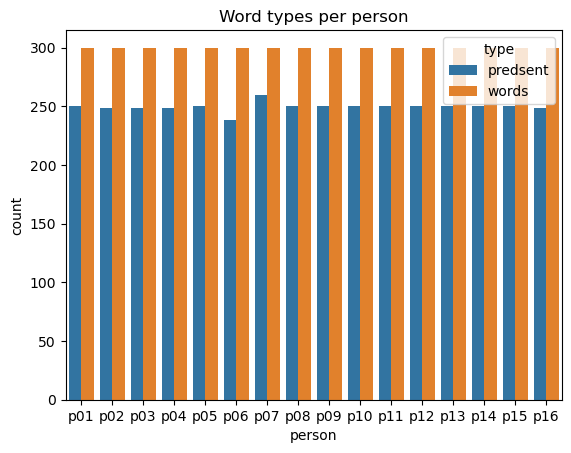

In [12]:
plt.title('Word types per person')
df_words_per_person = df_vnts.groupby(['person','type']).size().to_frame(name='count').reset_index()
sns.barplot(data=df_words_per_person, x='person', y='count', hue='type')
# Alternatively, use seaborn's countplot:
# sns.countplot(data=df, x='person', hue='type')
plt.show()

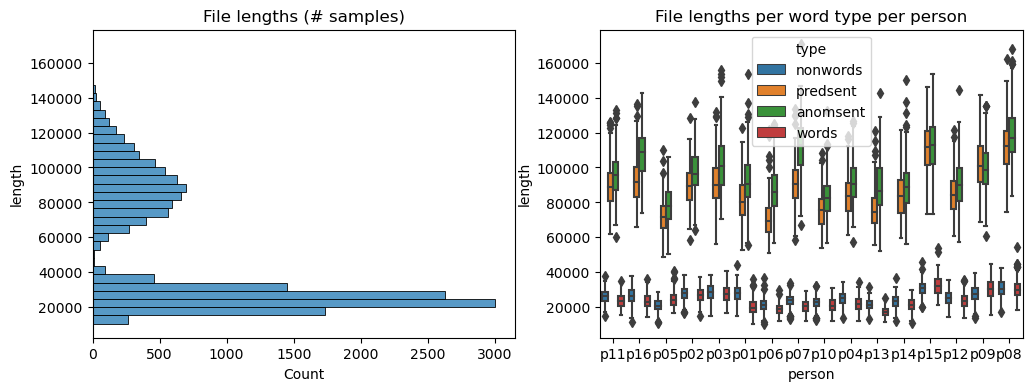

In [30]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('File lengths (# samples)')
sns.histplot(data=df_vnts, y='length')

fig.add_subplot(122)
plt.title('File lengths per word type per person')
sns.boxplot(data=df_vnts, x='person', y='length', hue='type')

plt.show()

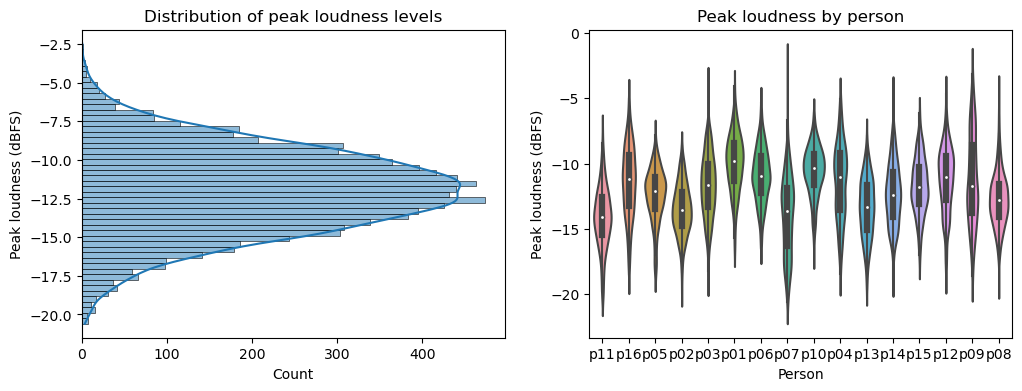

In [27]:
fig = plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title('Distribution of peak loudness levels')
sns.histplot(data=df_vnts, y='max_dBFS', kde=True)
plt.ylabel('Peak loudness (dBFS)')

plt.subplot(122)
plt.title('Peak loudness by person')
sns.violinplot(data=df_vnts, x='person', y='max_dBFS')
plt.xlabel('Person')
plt.ylabel('Peak loudness (dBFS)')

plt.show()

The loudness is already normalized for every sample:

In [20]:
np.unique(df_vnts.dBFS)

array([-28.98248019])

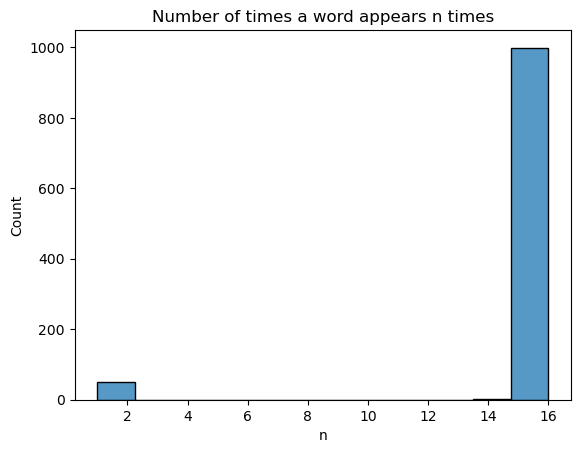

In [8]:
df_word_counts = df_vnts.groupby(['word']).size().to_frame(name='count').reset_index()

plt.title('Number of times a word appears n times')
plt.xlabel('n')
sns.histplot(data=df_word_counts, x='count')
plt.show()

<AxesSubplot:xlabel='length', ylabel='Count'>

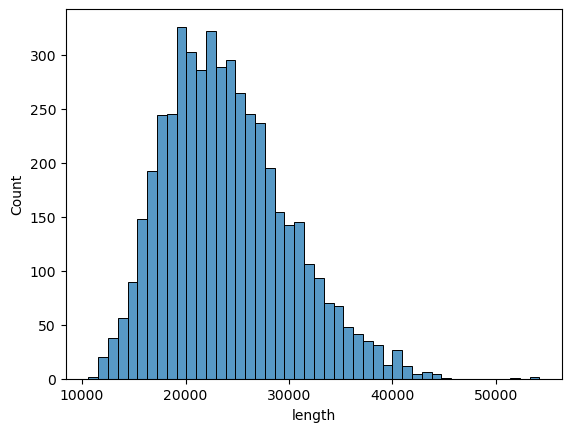

In [13]:
sns.histplot(data=df_vnts[df_vnts.type == 'words'], x='length')

In [33]:
df_vnts[df_vnts.type == 'words'].length.quantile(q=[0.5,0.7,0.75,0.8,0.84,0.9,0.95,0.99])

0.50    23322.00
0.70    26693.50
0.75    27652.75
0.80    28860.40
0.84    30080.60
0.90    32187.00
0.95    35061.15
0.99    40267.10
Name: length, dtype: float64

In [37]:
len(df_vnts[(df_vnts.type == 'words') & (df_vnts.length >= 40267)])

49

### Anomaly Detection


In [14]:
max_len = int(df_vnts.length.max())

def get_fft_from_file(inp: Tuple[int, pd.Series]):
    """
    inp : A tuple of the row index in the source dataframe and a pandas Series
        with row values
    """
    idx, row = inp

    sound = AudioSegment.from_file(row.path)

    sample_rate = sound.frame_rate
    length = int(sound.frame_count())
    data = np.array(sound.get_array_of_samples())

    # Append zeros to bring to same length
    if length < max_len:
        data = np.append(data, np.zeros((max_len - length, )))

    # Compute fft
    _, fft = dataproc.compute_fft(data, sample_rate)

    # Downsample by casting to 16-bit unsigned integer
    fft = np.uint16(fft)
    
    return fft

In [15]:
ffts = dp.DataProcessor.multi_proc(
    iterator = df_vnts.iterrows(),
    F = get_fft_from_file,
    total = len(df_vnts),
    num_processes = NUM_PROCESSES,
)

100%|██████████| 8794/8794 [00:46<00:00, 188.13it/s]


In [16]:
ffts_pca = PCA(n_components=3).fit_transform(ffts)

In [17]:
df_vnts['x_pca'], df_vnts['y_pca'], df_vnts['z_pca'] = ffts_pca[:, 0], ffts_pca[:, 1], ffts_pca[:, 2]

In [19]:
fig = px.scatter_3d(df_vnts, x='x_pca', y='y_pca', z='z_pca', color='type', hover_data=['person', 'word', 'type'])
fig.show()

### Silence Detection

In [15]:
sample_file = df_vnts.sample().path.values[0]

Silent sections found at milliseconds:
[]


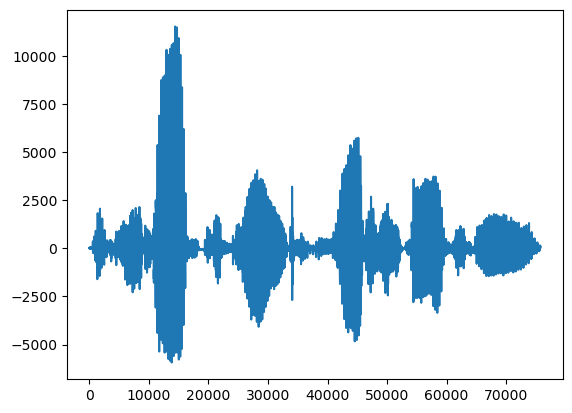

In [16]:
plot_silence(sample_file, min_silence_len=50, silence_thresh=-60)

## IFA Dialog

### Loading

In [5]:
path_extension = 'cuts/'

path = DataPaths.IFA_Dialog #/ path_extension

# audio_files = [path + fn for fn in os.listdir(path) if fn.split('.')[-1] == 'wav']
# print(audio_files)

In [6]:
audio_files = [ fn for fn in sorted(os.listdir(path)) if fn.split('.')[-1] == 'wav']
print(f"Total no. of audio files: {len(audio_files)}")

sample_rates, sample_lenghts = [], []

for fn in audio_files:
    freq_sample, sig_audio = wavfile.read(path/fn)

    sample_rates.append(freq_sample)
    sample_lenghts.append(sig_audio.shape[0])

    #print(f'File: {fn}; Sample Rate: {freq_sample} Hz; Length: {sig_audio.shape[0]} samples; Duration {round(sig_audio.shape[0] / float(freq_sample), 2)} seconds')

print(f"\nUnique sampling rates:")
for x in np.unique(sample_rates):
    print(f" {x}: {sample_rates.count(x)} times")

print(f"\nUnique file lengths:")
for x in np.unique(sample_lenghts):
    print(f" {x}: {sample_lenghts.count(x)} times")

Total no. of audio files: 24


Unique sampling rates:
 48000: 24 times

Unique file lengths:
 41721600: 1 times
 43200000: 23 times


### General Analysis

There is only one file that is shorter than the others: DVA21AJ.wav. Let's see if it's beginning or end seems cut off:

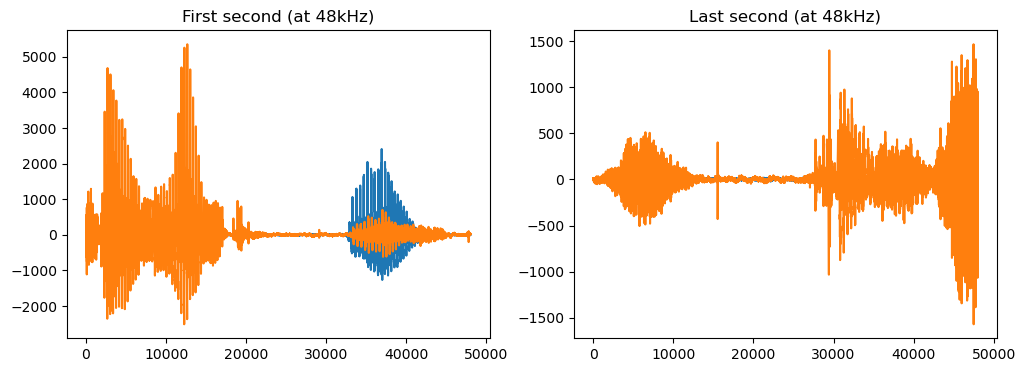

In [48]:
freq_sample, sig_audio = wavfile.read(path/'DVA21AJ.wav')
ipd.Audio(sig_audio[:20000], rate=freq_sample)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("First second (at 48kHz)")
plt.plot(sig_audio[:48000])
plt.subplot(122)
plt.title("Last second (at 48kHz)")
plt.plot(sig_audio[-48000:])
plt.show()

It does seem like it. Unfortunately, I cannot listen to these long samples through Jupyter for whatever reason, even if only taking shorter sections from them.

There is also the **cuts** version of the dataset, with the before used audio files cut into short segments, and split per speaker. 

From random hearing samples, it does not seem like the cut is perfect (i.e. sometimes you can here the other speaker, too), and it is noticable that non-speech parts like laughter are also present. 

It is also not clear to me at this point what algorithm was used for producing the cuts, as this is not mentioned on the dataset's website.

Let's do the same analysis again with the cuts data:

In [6]:
path = DataPaths.IFA_Dialog / 'cuts'

# Get .wav files
audio_files = [ fn for fn in sorted(os.listdir(path)) if fn.split('.')[-1] == 'wav']

NUM_PROCESSES = 15

def f(fn):
    freq_sample, sig_audio = wavfile.read(path/fn)

    parent = fn.split('_')[0]
    speaker = fn.split('_')[-2]
    segment  = fn.split('_')[-1].split('.')[0]
    dialoogcode = 'dialoogcode' in fn

    return [
        str(path/fn),
        parent,
        speaker,
        segment,
        dialoogcode,
        sig_audio.shape[0], 
        freq_sample
    ]

with Pool(NUM_PROCESSES) as p:
    res_list = []
    for result in tqdm(p.imap(f, audio_files), total=len(audio_files)):
        res_list.append(result)

df_ifad_cuts = pd.DataFrame(
    res_list,
    columns=['path','parent','speaker','segment','dialoogcode','length','sample_rate']
)

del res_list

100%|██████████| 27852/27852 [00:33<00:00, 840.90it/s] 


In [9]:
df_ifad_cuts.head()

path  ... sample_rate
0  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  ...       48000
1  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  ...       48000
2  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  ...       48000
3  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  ...       48000
4  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  ...       48000

[5 rows x 7 columns]

In [116]:
file = df_ifad_cuts.sample().path.values[0]
print(file)
freq_sample, sig_audio = wavfile.read(path/file)
ipd.Audio(sig_audio, rate=freq_sample)

/data/julber/Dutch_spoken_datasets/IFA_Dialog/cuts/DVA2C_dialoogcode_spreker2_562.wav


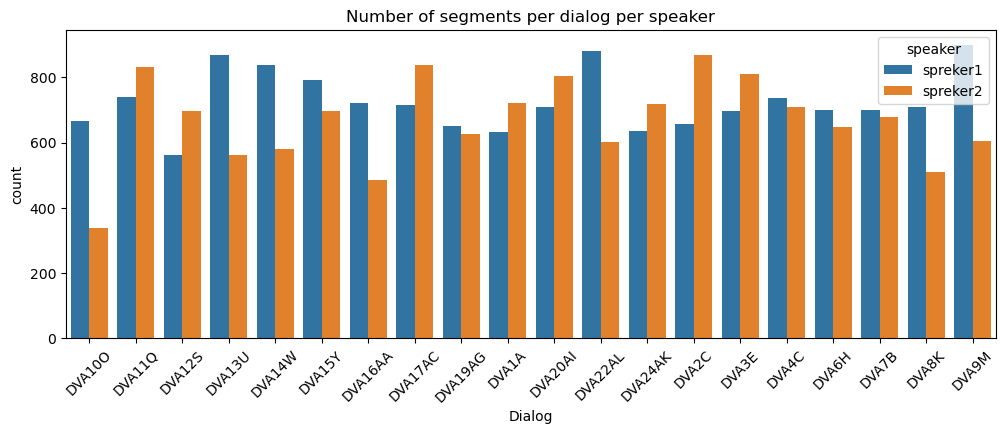

In [102]:
plt.figure(figsize=(12,4))
plt.title('Number of segments per dialog per speaker')
sns.countplot(data=df_ifad_cuts, x='parent', hue='speaker')
plt.xlabel("Dialog")
plt.xticks(rotation = 45)
plt.show()

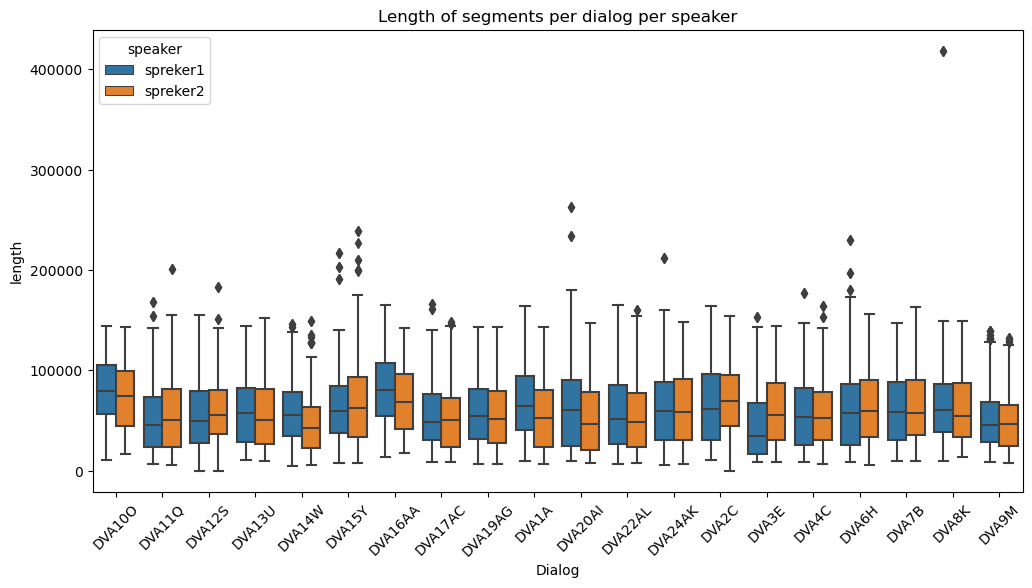

In [99]:
plt.figure(figsize=(12,6))
plt.title('Length of segments per dialog per speaker')
sns.boxplot(data=df_ifad_cuts, x='parent', y='length', hue='speaker')
plt.xticks(rotation = 45)
plt.xlabel("Dialog")
plt.show()

There are also empty files, in the dialogs DVA12S and DVA2C, from both speakers, but seemingly in succession, for both dialoogcode and non-dialoogcode:

In [274]:
print("No. empty files:",len(df_ifad_cuts[df_ifad_cuts.length == 0]))
df_ifad_cuts[df_ifad_cuts.length == 0]

No. empty files: 14


path  parent   speaker  \
2824   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker1   
3173   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
3174   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
3175   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
3454   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker1   
3813   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
3814   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
3815   /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA12S  spreker2   
18647  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   
18648  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   
18649  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   
19412  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   
19413  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   
19414  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...   DVA2C  spreker2   

      segment  dialoogcode  length  sample_rate  
2824      507         True       0        48000  
3173      596         True       0        48000  
3174      597         True       0        48000  
3175      599         True       0        48000  
3454      507        False       0        48000  
3813      596        False       0        48000  
3814      597        False       0        48000  
3815      599        False       0        48000  
18647     602         True       0        48000  
18648     604         True       0        48000  
18649     605         True       0        48000  
19412     602        False       0        48000  
19413     604        False       0        48000  
19414     605        False       0        48000

### Dialoogcode

Let's take a look at the difference between segments labeled with "dialoogcode" and those that are not. 

First, we see that there is actually and unequal amount between the two, even though they seem to always correspond to an actual one:

In [ ]:
df_ifad_cuts.groupby('dialoogcode').size()

dialoogcode
False    14032
True     13820
dtype: int64

Further, we see that both number and length of dialoogcode vs. non-dialoogcode items differs:

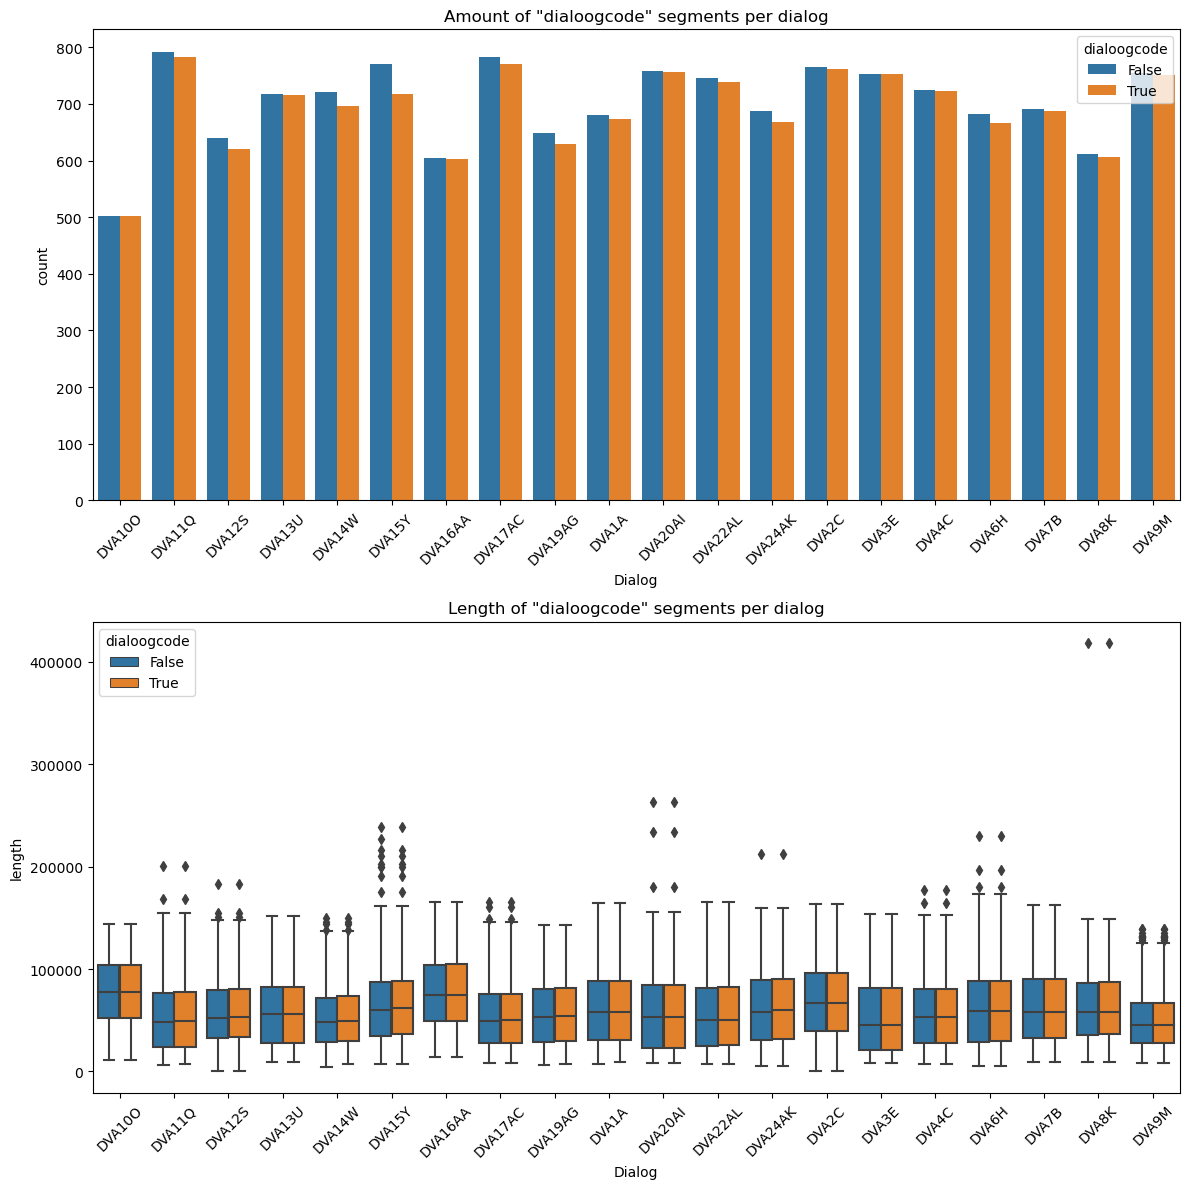

In [134]:
plt.figure(figsize=(12,12))

plt.subplot(211)
plt.title('Amount of "dialoogcode" segments per dialog')
sns.countplot(data=df_ifad_cuts, x='parent', hue='dialoogcode')
plt.xticks(rotation = 45)
plt.xlabel("Dialog")

plt.subplot(212)
plt.title('Length of "dialoogcode" segments per dialog')
sns.boxplot(data=df_ifad_cuts, x='parent', y='length', hue='dialoogcode')
plt.xticks(rotation = 45)
plt.xlabel("Dialog")

plt.tight_layout()
plt.show()

In [ ]:
i = 0
while True:
    sample = df_ifad_cuts.sample().iloc[0]
    path = sample["path"]

    if i % 100 == 0 : print(i)

    # If true, remove from filename
    if sample["dialoogcode"]:
        opp_path = path.replace("_dialoogcode", "")

    # If false, add to filename
    else:
        split_path = path.split('_')
        split_path.insert(-2, 'dialoogcode')
        opp_path = "_".join(split_path)

    if opp_path in df_ifad_cuts["path"]:
        length_orig = df_ifad_cuts[df_ifad_cuts["path"] == path].length.values[0]
        length_opp = df_ifad_cuts[df_ifad_cuts["path"] == opp_path].length.values[0]
        if length_orig != length_opp:
            break
        else:
            print("Lengths are the same")
    else:
        print('Opposite not found')

    i += 1

print('Found one!')
print(path)
print(opp_path)

# Create opposite
# sample_opp = sample["dialoogcode"].replace([True, False], [False, True])
# Check if opposite is present
# print(sample_opp)
# df_ifad_cuts.isin(sample)

# sample_opp = df_ifad_cuts

# df_ifad_cuts_dg = df_ifad_cuts[df_ifad_cuts["dialoogcode"] == True]
# df_ifad_cuts_non_dg = df_ifad_cuts[df_ifad_cuts["dialoogcode"] != True]
# print(df_ifad_cuts_non_dg.head())
# print(df_ifad_cuts_dg.head())
# df_dg_compare = df_ifad_cuts_non_dg.compare(df_ifad_cuts_dg)
# df_dg_compare.head()

In [222]:
print(path)
print(opp_path)

/data/julber/Dutch_spoken_datasets/IFA_Dialog/cuts/DVA1A_spreker2_91.wav
/data/julber/Dutch_spoken_datasets/IFA_Dialog/cuts/DVA1A_dialoogcode_spreker2_91.wav


In [225]:
df_ifad_cuts[df_ifad_cuts["path"] == path]

path parent   speaker  \
13563  /data/julber/Dutch_spoken_datasets/IFA_Dialog/...  DVA1A  spreker2   

      segment  dialoogcode  length  sample_rate  
13563      91        False  103636        48000

In [ ]:
file_dg = '/data/julber/Dutch_spoken_datasets/IFA_Dialog/cuts/DVA2C_dialoogcode_spreker2_562.wav'
file_non_dg = '/data/julber/Dutch_spoken_datasets/IFA_Dialog/cuts/DVA2C_spreker2_562.wav'

freq_sample, dg = wavfile.read(path/file)
freq_sample, non_dg = wavfile.read(path/file)

# ipd.Audio(sig_audio, rate=freq_sample)

plt.plot(dg)
plt.show()
plt.plot(non_dg)
(dg == non_dg).all()

### Anomaly Detection

In [11]:
fn = df_ifad_cuts.sample().path.values[0]
freq_sample, sig_audio = wavfile.read(path/fn)

In [8]:
# Filter out dialoogcode segments and those with length 0
df_filtered = df_ifad_cuts[(df_ifad_cuts["dialoogcode"]==False) & (df_ifad_cuts["length"] != 0)]

# Get length of longest file to pad all others
max_len = df_filtered.length.max()

# For testing purposes, comment out this line
# df_filtered = shuffle(df_filtered)[:1000]

In [15]:
reload(dp)
dataproc = dp.DataProcessor(data_path = path, max_len = max_len)

In [11]:
ffts, fnames, labels, lengths = dataproc.compute_ffts_IFAD(df_filtered, 15)

100%|██████████| 14025/14025 [02:52<00:00, 81.17it/s]


In [16]:
def comp_fft_ifad(inp):
    idx, row = inp

    # Read file
    fn = row.path
    freq_sample, sig_audio = wavfile.read(self.data_path/fn)
    length = sig_audio.shape[0]

    # Append zeros to bring to same length
    if sig_audio.shape[0] < self.max_len:
        sig_audio = np.append(sig_audio, np.zeros((self.max_len - sig_audio.shape[0], )))

    # Compute fft
    _, fft = self.compute_fft(sig_audio, freq_sample)

    fft = np.uint16(fft)

    fname = fn.split('/')[-1]
    label = row.parent
    
    return [fft, fname, label, length]


In [104]:
# Set the number of processes to spawn for multiprocessing
NUM_PROCESSES = 8

def f(inp):
    idx, row = inp

    # Read file
    fn = row.path
    freq_sample, sig_audio = wavfile.read(path/fn)
    length = sig_audio.shape[0]

    # Append zeros to bring to same length
    if sig_audio.shape[0] < max_len:
        sig_audio = np.append(sig_audio, np.zeros((max_len - sig_audio.shape[0], )))

    # Compute fft
    _, fft = dataproc.compute_fft(sig_audio, freq_sample)

    fname = fn.split('/')[-1]
    label = row.parent
    
    return [fft, fname, label, length]

with Pool(NUM_PROCESSES) as p:
    res_list = []
    for result in tqdm(p.imap(f, df_filtered.iterrows()), total=len(df_filtered)):
        res_list.append(result)

ffts, fnames, labels, lengths = zip(*res_list)
del res_list

100%|██████████| 1000/1000 [00:15<00:00, 66.12it/s]


In [43]:
utils.varinfo(df_filtered)
utils.varinfo(df_ifad_cuts)

Type: <class 'pandas.core.frame.DataFrame'>
Size: 343.46 kB (343460 Bytes)
Type: <class 'pandas.core.frame.DataFrame'>
Size: 9.51 MB (9508282 Bytes)


In [111]:
reload(utils)
utils.getmeminfo(items = locals().items())

                  df_ifad_cuts:  9.1 MiB
                        res_df: 335.7 KiB
                   df_filtered: 335.4 KiB
                    pca_res_df: 242.0 KiB
                   audio_files: 240.7 KiB
                     sig_audio: 144.2 KiB
                        y_pred:  7.9 KiB
                      outliers:  7.9 KiB
                          ffts:  7.9 KiB
                        fnames:  7.9 KiB
                        labels:  7.9 KiB
                       lengths:  7.9 KiB
                          tqdm:  2.0 KiB
            LocalOutlierFactor:  2.0 KiB
                          TSNE:  2.0 KiB
                           PCA:  1.4 KiB
                           Out:  1.1 KiB
                            In:  1.1 KiB
                     DataPaths:  1.0 KiB
                          Path:  896.0 B
                    (+ 42 more)


In [59]:
# Cast to numpy array
ffts = np.array(ffts, dtype=np.uint16)

In [ ]:
# Normalize
# unnormed_ffts = ffts
ffts -= np.mean(ffts, axis=0)
ffts /= np.std(ffts, axis=0)
# ffts = (ffts - np.mean(ffts, axis=0)) / np.std(ffts, axis=0)

In [44]:
# Perform PCA
pca = PCA(n_components=3)
ffts_pcs = pca.fit_transform(ffts)

In [92]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=2, contamination=0.4)

outliers = lof.fit_predict(ffts)

In [102]:
from sklearn.manifold import TSNE

ffts_tsne = TSNE(n_components=3, init='random').fit_transform(ffts)

/home/passch/.conda/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [103]:
# Collect results in DataFrame
all_res = np.empty((ffts_pcs.shape[0], 10), dtype=object)
all_res[:,:3] = ffts_pcs
all_res[:,3:6] = ffts_tsne
all_res[:,6] = labels
all_res[:,7] = fnames
all_res[:,8] = lengths
all_res[:,9] = outliers
res_df = pd.DataFrame(all_res, columns=['x_pca','y_pca','z_pca','x_tsne','y_tsne','z_tsne','label','file','length','outlier'])
del all_res

# Convert outliers to boolean
res_df.outlier = res_df.outlier.replace([-1,1], [True, False])

# Cast lengths to float to allow Plotly to display it on a continuous colorscale
res_df.length = res_df.length.astype(float)

res_df.head()

x_pca           y_pca          z_pca     x_tsne      y_tsne  \
0 -4097585.649624    376850.53663  399875.507193 -29.415661  -59.994049   
1 -1268878.515283   -95729.898856  365890.640675  -6.863472   73.472664   
2  2680427.466653  -271705.037645 -432640.014679  16.613758    8.629041   
3  5069334.005108  1562364.286666  154863.783722   21.44652  117.143723   
4 -5059201.641586  1482581.203748 -180522.573541 -25.453491  -88.415344   

      z_tsne    label                      file   length  outlier  
0  34.846561    DVA3E    DVA3E_spreker1_417.wav  61220.0     True  
1  75.602776  DVA22AL  DVA22AL_spreker2_235.wav  22292.0    False  
2 -92.693451    DVA9M    DVA9M_spreker1_585.wav  33614.0     True  
3 -32.985687  DVA16AA    DVA16AA_spreker2_6.wav  51055.0    False  
4  77.528198    DVA3E    DVA3E_spreker1_187.wav  36804.0     True

In [110]:
fig = px.scatter_3d(res_df, x='x_tsne', y='y_tsne', z='z_tsne', color='outlier', hover_data=['file'])
fig.show()

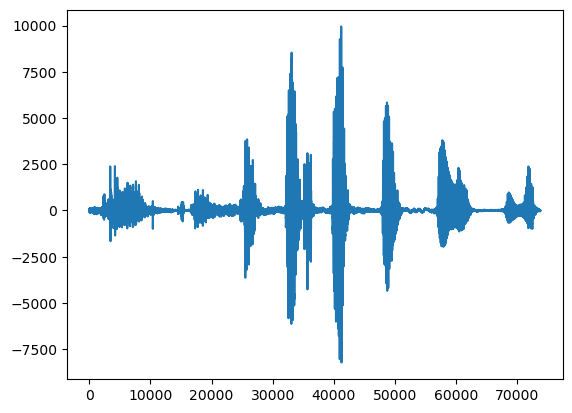

In [107]:
# clipping:
fn = 'DVA11Q_spreker1_120.wav'
# laughter:
fn = 'DVA13U_spreker1_183.wav'
fn = 'DVA10O_spreker1_473.wav'
fn = 'DVA10O_spreker2_245.wav'
fn = 'DVA12S_spreker2_503.wav'
fn = 'DVA12S_spreker1_477.wav'
fn = 'DVA24AK_spreker2_367.wav'
fn = 'DVA24AK_spreker1_8.wav'

fn = 'DVA15Y_spreker1_242.wav'
fn = 'DVA15Y_spreker2_414.wav'

freq_sample, sig_audio = wavfile.read(path/fn)

plt.plot(sig_audio)
plt.show()

ipd.Audio(sig_audio, rate=freq_sample)

### Unsorted Rest

In [79]:
# start = 22000000
# length = 5000000

freq_sample, sig_audio = wavfile.read(audio_files[3])
# print(f'Channel 1 std: {round(np.std(sig_audio[:,0]), 2)} | Channel 2 std: {round(np.std(sig_audio[:,1]),2)}')
# sig_audio = sig_audio[start:start+length]

freq_sample2, sig_audio2 = wavfile.read(audio_files[5])
# print(f'Channel 1 std: {round(np.std(sig_audio2[:,0]), 2)} | Channel 2 std: {round(np.std(sig_audio2[:,1]),2)}')
# sig_audio2 = sig_audio2[start:start+length]

In [51]:
# f, t, Zxx = signal.stft(sig_audio[:40000, 0], fs=freq_sample)
# plt.pcolormesh(t, f, np.abs(Zxx), cmap='viridis')

In [80]:
print(sig_audio.shape, sig_audio2.shape)

(16754,) (19590,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


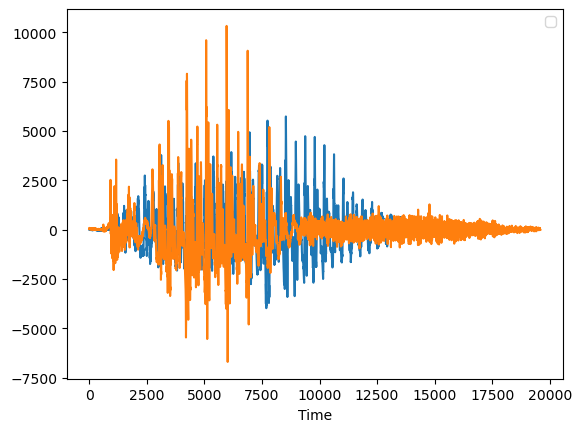

In [65]:
# plt.plot(sig_audio[:,0], label='ch. 1')
# plt.plot(sig_audio[:,1], label='ch. 2')
plt.plot(sig_audio)
plt.plot(sig_audio2)
plt.xlabel('Time')
plt.legend()
plt.show()

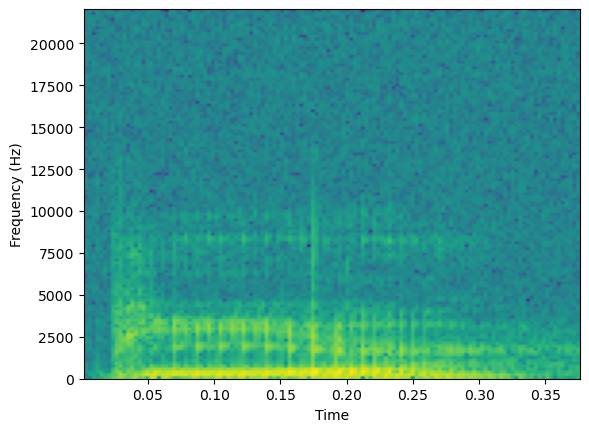

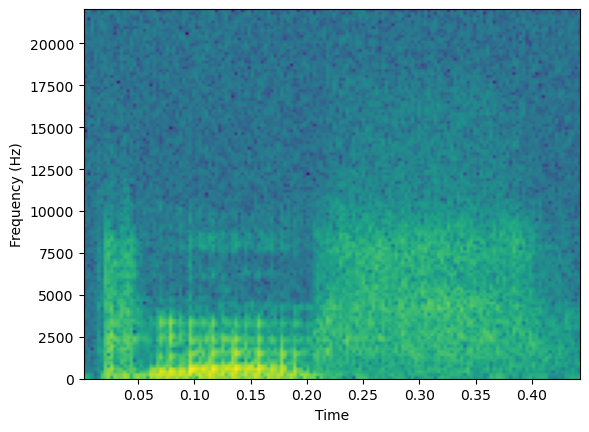

In [66]:
# for dim in [0,1]:
#     plt.specgram(sig_audio[:,dim], cmap='viridis', Fs=freq_sample)
#     plt.xlabel('Time')
#     plt.ylabel('Frequency (Hz)')
#     plt.show()

plt.specgram(sig_audio, cmap='viridis', Fs=freq_sample)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.specgram(sig_audio2, cmap='viridis', Fs=freq_sample)
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

/tmp/ipykernel_2173595/767118036.py:6: FutureWarning: Pass y=[ 44.  15.   4. ... -29.   0. -35.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(sig_audio, sr=freq_sample, n_mels=128)


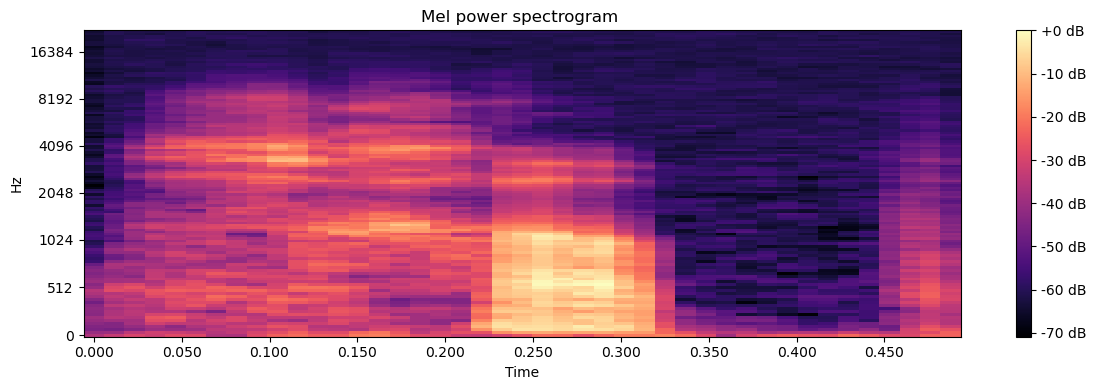

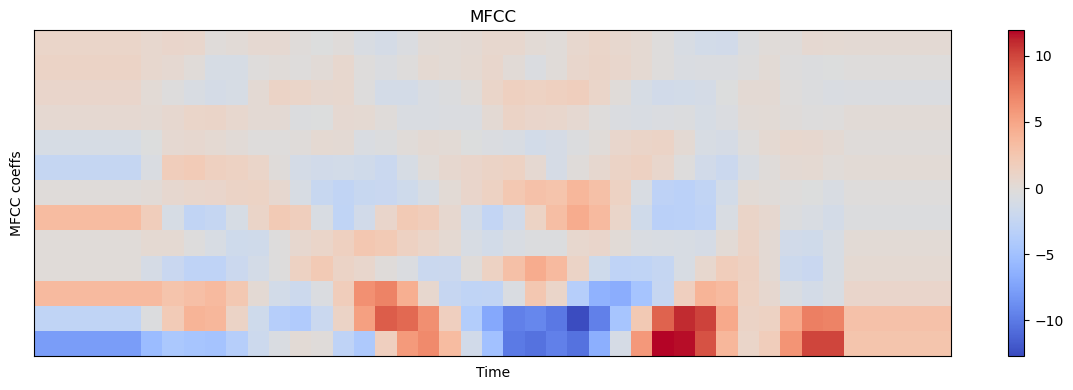

In [94]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

sig_audio = np.array(sig_audio, dtype=float)

S = librosa.feature.melspectrogram(sig_audio, sr=freq_sample, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=freq_sample, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()


In [68]:
# Extracting the length and the half-length of the signal to input to the fourier transform
sig_length = len(sig_audio)
half_length = np.ceil((sig_length + 1) / 2.0).astype(int)

# We will now be using the Fourier Transform to form the frequency domain of the signal
signal_freq = np.fft.fft(sig_audio)

# Normalize the frequency domain and square it
signal_freq = abs(signal_freq[0:half_length]) / sig_length
signal_freq **= 2
transform_len = len(signal_freq)

# The Fourier transformed signal now needs to be adjusted for both even and odd cases
if sig_length % 2:
  signal_freq[1:transform_len] *= 2
else:
  signal_freq[1:transform_len-1] *= 2
  
# Extract the signal's strength in decibels (dB)
exp_signal = 10 * np.log10(signal_freq)
x_axis = np.arange(0, half_length, 1) * (freq_sample / sig_length) / 1000.0

plt.plot(x_axis, exp_signal[:,0], linewidth=1)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed


MFCC Parameters
Window Count = 49
Individual Feature Length = 13


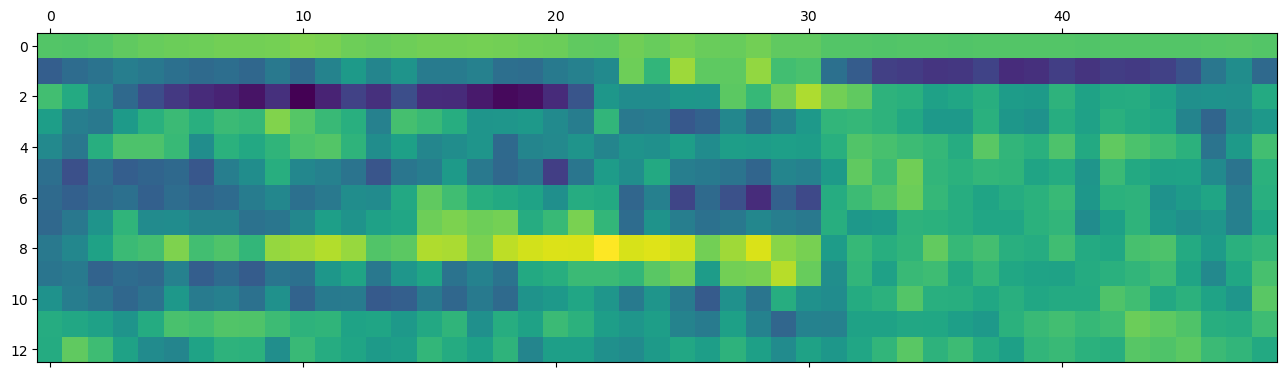

In [95]:
# Installing and importing necessary libraries
from python_speech_features import mfcc, logfbank

# Using MFCC to extract features from the signal
mfcc_feat = mfcc(sig_audio, freq_sample)
print('\nMFCC Parameters\nWindow Count =', mfcc_feat.shape[0])
print('Individual Feature Length =', mfcc_feat.shape[1])

mfcc_feat = mfcc_feat.T

plt.matshow(mfcc_feat)
plt.show()


Filter bank
Window Count = 49
Individual Feature Length = 26

Filter bank
Window Count = 43
Individual Feature Length = 26


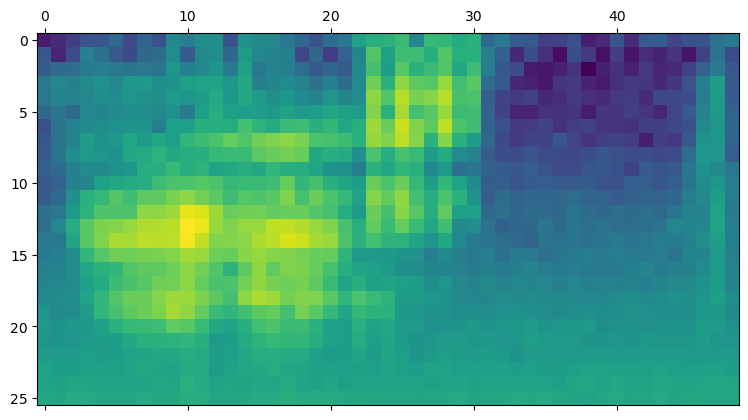

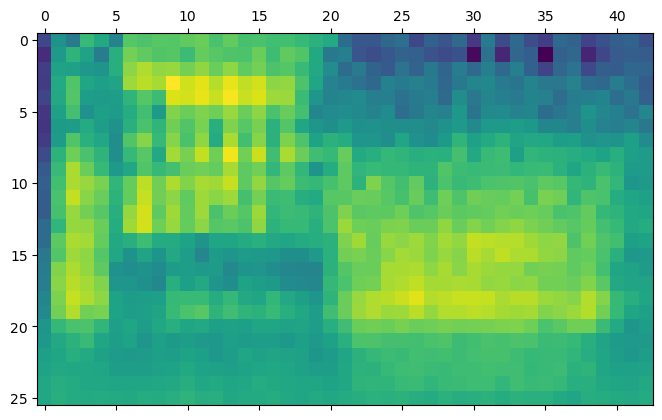

In [96]:
def plot_logfbank(sig_audio):
    # Generating filter bank features
    fb_feat = logfbank(sig_audio, freq_sample)
    print('\nFilter bank\nWindow Count =', fb_feat.shape[0])
    print('Individual Feature Length =', fb_feat.shape[1])

    fb_feat = fb_feat.T

    plt.matshow(fb_feat)

plot_logfbank(sig_audio)
plot_logfbank(sig_audio2)

## IFA

In [151]:
path = DataPaths.IFA/'fm'

audio_files = [
    str(path/speaker/fn) for speaker in os.listdir(path)
        for fn in os.listdir(path/speaker) 
]

NUM_PROCESSES = 8

def extract_IFA(fn):

    sound = AudioSegment.from_file(fn)
    # res = aifc.open(fn)

    split = fn.split('/')
    speaker = split[-2]
    filename = split[-1].split('.')[0]

    # sample_rate = res.getframerate()
    sample_rate = sound.frame_rate
    # length = res.getnframes()
    length = sound.frame_count()
    duration = sound.duration_seconds
    dBFS = sound.dBFS
    max_dBFS = sound.max_dBFS

    return [
        str(path/fn),
        speaker,
        filename,
        sample_rate,
        length,
        duration,
        dBFS,
        max_dBFS,
    ]

with Pool(NUM_PROCESSES) as p:
    res_list = []
    for result in tqdm(p.imap(extract_IFA, audio_files), total=len(audio_files)):
        res_list.append(result)

df_ifa = pd.DataFrame(
    res_list,
    columns=['path','speaker','filename','sample_rate','length','duration', 'dBFS', 'max_dBFS']
)

del res_list

100%|██████████| 4450/4450 [03:56<00:00, 18.79it/s]


In [ ]:
getmeminfo(locals().items())

In [152]:
df_ifa.head()

path speaker  \
0  /data/julber/Dutch_spoken_datasets/IFA/fm/F60E...    F60E   
1  /data/julber/Dutch_spoken_datasets/IFA/fm/F60E...    F60E   
2  /data/julber/Dutch_spoken_datasets/IFA/fm/F60E...    F60E   
3  /data/julber/Dutch_spoken_datasets/IFA/fm/F60E...    F60E   
4  /data/julber/Dutch_spoken_datasets/IFA/fm/F60E...    F60E   

           filename  sample_rate    length   duration       dBFS  max_dBFS  
0  F60E1FPA2VCVB_fm        44100  133391.0   3.024739 -19.753824 -1.481695  
1      F60E2VY6A_fm        44100  476596.0  10.807166 -19.938720 -0.116616  
2      F60E2VT9D_fm        44100  607729.0  13.780703 -18.377057  0.000000  
3      F60E1FY5A_fm        44100  478880.0  10.858957 -22.690309 -2.930994  
4      F60E2VT5D_fm        44100  148796.0   3.374059 -17.893789  0.000000

In [214]:
len(df_ifa)

4450

### High level analysis

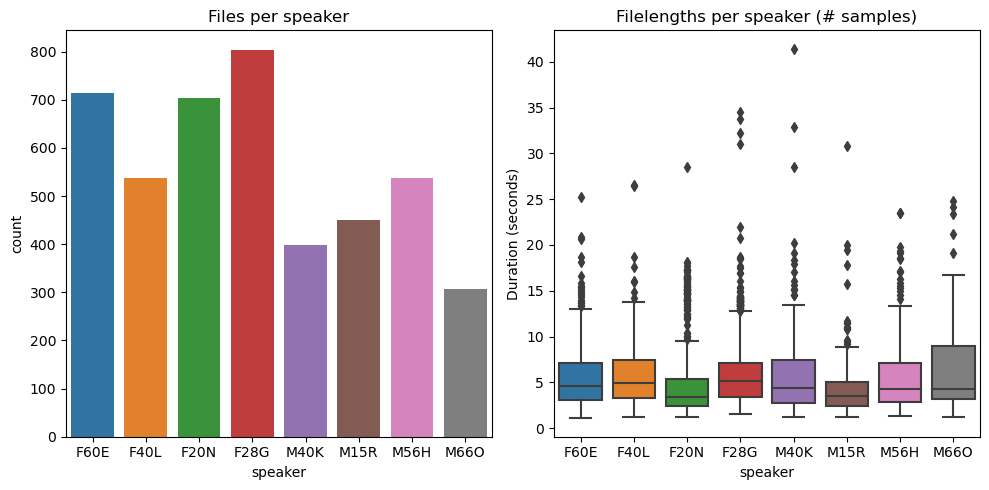

Min and max length: 47863.0 1826104.0


In [154]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Files per speaker")
sns.countplot(data=df_ifa, x='speaker')

plt.subplot(122)
plt.title("Filelengths per speaker (# samples)")
sns.boxplot(data=df_ifa, x='speaker', y='duration')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

print("Min and max length:", df_ifa.length.min(), df_ifa.length.max())

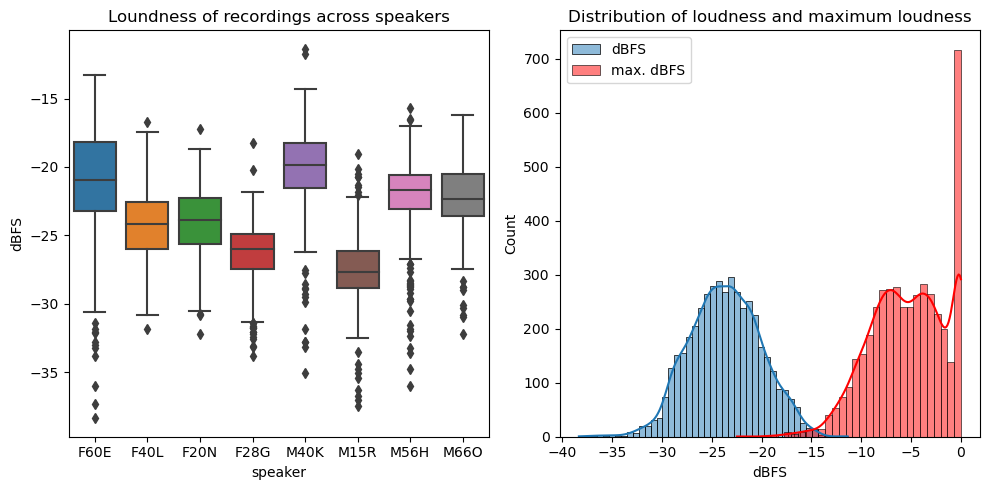

In [168]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Loundness of recordings across speakers')
sns.boxplot(data=df_ifa, x='speaker', y='dBFS')

plt.subplot(122)
plt.title('Distribution of loudness and maximum loudness')
sns.histplot(data=df_ifa, x='dBFS', label='dBFS', kde=True)
sns.histplot(data=df_ifa, x='max_dBFS', color='red', label='max. dBFS', kde=True)
plt.legend()

plt.tight_layout()
plt.show()

We can see that there is a high variance of loudness between the recordings.

Further, there seem to be a large number of recordings with max loudness around zero. This could be caused by clipping. Let's look at it:

In [193]:
zero_max_dBFS = df_ifa[df_ifa.max_dBFS == 0]
len(zero_max_dBFS)

420

In [184]:
sample_file = zero_max_dBFS.sample()

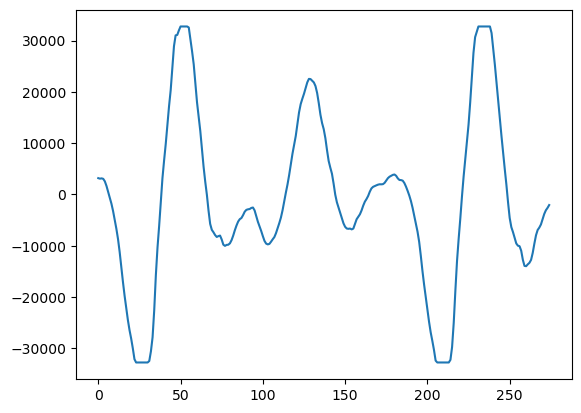

In [192]:
# df_ifa[(df_ifa.max_dBFS > -1) & (df_ifa.max_dBFS < 0)]
sound = AudioSegment.from_file(sample_file.path.values[0])
plt.plot(sound.get_array_of_samples()[35550:35825])
# df_ifa.sort_values('max_dBFS')
sound

_aifc_params(nchannels=1, sampwidth=2, framerate=44100, nframes=189896, comptype=b'NONE', compname=b'')


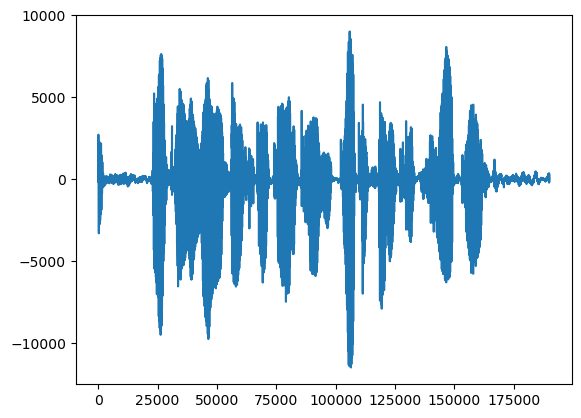

In [155]:
rand_idx = np.random.choice(range(len(audio_files)))

res = aifc.open(audio_files[rand_idx])
print(res.getparams())

data  = res.readframes(res.getnframes())
res.rewind()

a = np.frombuffer(data, dtype = np.short).byteswap()

plt.plot(a)
ipd.Audio(a, rate= res.getframerate())

### Silence detection

In [202]:
rand_idx = np.random.choice(range(len(audio_files)))

In [205]:
27852  + 4450 + 3394  + 8445

44141

Silent sections found at milliseconds:
[[0, 559], [1636, 2138], [2831, 3454], [3869, 4677], [5425, 6059], [6468, 7240], [8049, 8631], [9095, 9352]]


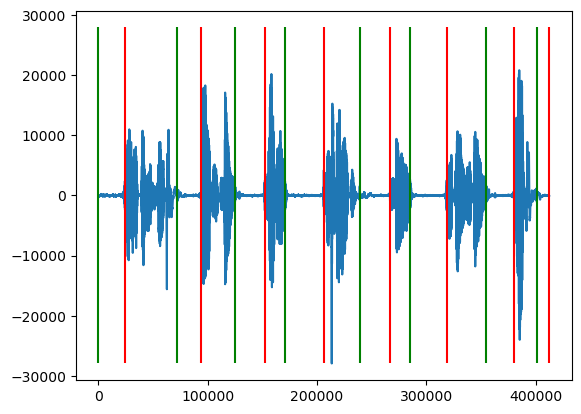

In [203]:
show_silence(audio_files[rand_idx], min_silence_len=150, silence_thresh=-40)

### Anomaly Detection

In [6]:
df_ifa = df_ifa[:1000]

In [9]:
# Set the number of processes to spawn for multiprocessing
NUM_PROCESSES = 12

max_len = df_ifa.length.max()

dataproc = dp.DataProcessor(data_path = path, max_len = max_len)

def f(inp):
    idx, row = inp

    # Read file
    res = aifc.open(row.path)

    sample_rate = res.getframerate()
    length = res.getnframes()

    data = res.readframes(length)
    sig_audio = np.frombuffer(data, dtype = np.short).byteswap()

    res.close()

    # Append zeros to bring to same length
    if length < max_len:
        sig_audio = np.append(sig_audio, np.zeros((max_len - length, )))

    # Compute fft
    _, fft = dataproc.compute_fft(sig_audio, sample_rate)

    fft = np.uint16(fft)

    fname = row.filename
    speaker = row.speaker
    
    return [fft, fname, speaker, length]

with Pool(NUM_PROCESSES) as p:
    res_list = []
    for result in tqdm(p.imap(f, df_ifa.iterrows()), total=len(df_ifa)):
        res_list.append(result)

ffts, fnames, speakers, lengths = zip(*res_list)
del res_list

100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s]


In [10]:
embeds = UMAP(n_components=3).fit_transform(ffts)

/home/passch/.conda/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Collect results in DataFrame
all_res = np.empty((len(ffts), 10), dtype=object)
all_res[:,:3] = embeds
all_res[:,3] = speakers
all_res[:,4] = fnames
all_res[:,5] = lengths
res_df = pd.DataFrame(all_res, columns=['x','y','z','speaker','file','length'])
del all_res

# Cast lengths to float to allow Plotly to display it on a continuous colorscale
res_df.length = res_df.length.astype(float)

res_df.head()

In [ ]:
fig = px.scatter_3d(res_df, x='x_tsne', y='y_tsne', z='z_tsne', color='outlier', hover_data=['file'])
fig.show()

## VoxForge

In [14]:
path = DataPaths.VoxForge

audio_files = [
    str(path/speaker/'wav'/fn) for speaker in os.listdir(path)
        for fn in os.listdir(path/speaker/'wav') if fn.split('.')[-1] == 'wav'
]

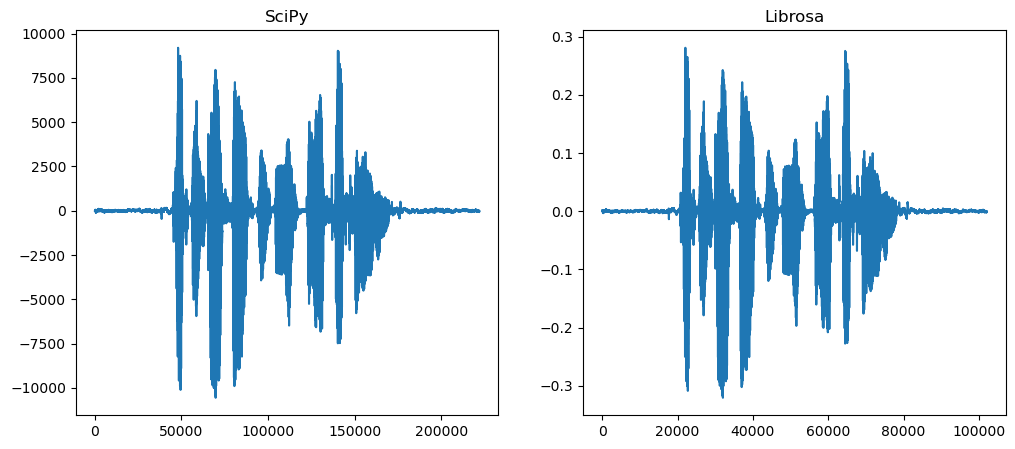

Scipy: 9202 -10558 (222000,) 48000 4.625
Librosa: 0.2809296 -0.32080966 (101982,) 22050 4.625034013605442


In [39]:
rand_idx = np.random.choice(len(audio_files))

sig_audio_lr, freq_sample_lr = librosa.load(audio_files[rand_idx], mono=True)
freq_sample, sig_audio = wavfile.read(audio_files[rand_idx])

# sig_audio_lr = sig_audio_lr * 32767

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('SciPy')
plt.plot(sig_audio)
plt.subplot(122)
plt.title('Librosa')
plt.plot(sig_audio_lr)
plt.show()

print("Scipy:", sig_audio.max(), sig_audio.min(), sig_audio.shape, freq_sample, sig_audio.shape[0] / freq_sample)
print("Librosa:", sig_audio_lr.max(), sig_audio_lr.min(), sig_audio_lr.shape, freq_sample_lr, sig_audio_lr.shape[0] / freq_sample_lr)

display(ipd.Audio(sig_audio, rate=freq_sample))
ipd.Audio(sig_audio_lr, rate=freq_sample_lr)

In [40]:
NUM_PROCESSES = 15

def f(fn):
    # try:
    # except wavfile.WavFileWarning:
    #     print(filename + "is Error")

    # freq_sample, sig_audio = wavfile.read(fn)
    sig_audio, freq_sample = librosa.load(fn)

    length = sig_audio.shape[0]
    duration = length / freq_sample

    speaker = fn.split('/')[-3] # 3rd to last and not 2nd, since every speaker
                                # has a 'wav' subdirectory
    filename = fn.split('/')[-1].split('.')[0]

    return [
        fn,
        speaker,
        filename,
        length,
        duration,
        freq_sample,
    ]

with Pool(NUM_PROCESSES) as p:
    res_list = []
    for result in tqdm(p.imap(f, audio_files), total=len(audio_files)):
        res_list.append(result)

df_voxforge = pd.DataFrame(
    res_list,
    columns=['path','speaker','filename','length','duration','sample_rate']
)

del res_list

100%|██████████| 8440/8440 [01:37<00:00, 86.91it/s] 


In [44]:
df_voxforge.head()

path                speaker  \
0  /data/julber/Dutch_spoken_datasets/VoxForge/48...  boergait-20080419-aqb   
1  /data/julber/Dutch_spoken_datasets/VoxForge/48...  boergait-20080419-aqb   
2  /data/julber/Dutch_spoken_datasets/VoxForge/48...  boergait-20080419-aqb   
3  /data/julber/Dutch_spoken_datasets/VoxForge/48...  boergait-20080419-aqb   
4  /data/julber/Dutch_spoken_datasets/VoxForge/48...  boergait-20080419-aqb   

  filename  length  duration  sample_rate  
0  nl-0401  112896  5.120000        22050  
1  nl-0398   99725  4.522676        22050  
2  nl-0404   80909  3.669342        22050  
3  nl-0400   94080  4.266667        22050  
4  nl-0403   67738  3.072018        22050

In [46]:
print('Number of speakers:',len(np.unique(df_voxforge.speaker)))
print('Number of files:', len(df_voxforge))

Number of speakers: 804
Number of files: 8440


Text(0.5, 0, 'Duration (s)')

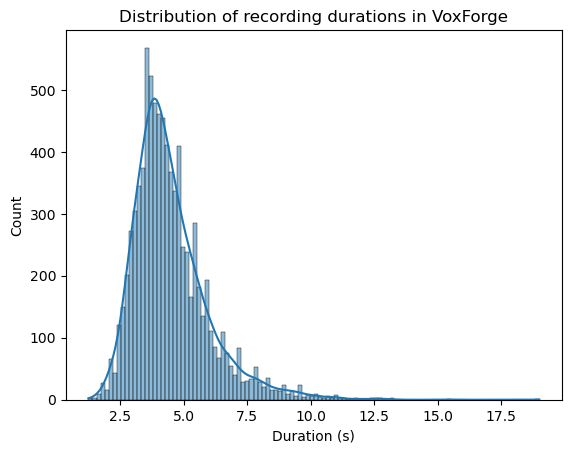

In [52]:
# sns.countplot(data=df_voxforge, x='speaker')
plt.title('Distribution of recording durations in VoxForge')
sns.histplot(data=df_voxforge, x='duration', kde=True)
plt.xlabel('Duration (s)')